# Example of use of the Concurrent_neural_network package


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from Concurrent_Neural_Network.preprocessing import filter_index_from_dataframe, compute_proportion, add_temporal_features, dataframe_to_data_loader
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

## I Data

The data we use are 92400 weekly sales of 550 smartphones on CDiscount website. It has 5 columns:
 - product_id : the name of the product
 - monday_date : the monday of the week (week are taken from monday to sunday)
 - sales : number of sales of the week
 - price : average price of the week
 - margin : average relative margin of the week 


### I.A Reading Data 

In [2]:
CUR_DIR = os.getcwd()
DATA_FILE = os.path.join(CUR_DIR,'data','smartphone_data.csv' )

In [3]:
data =  pd.read_csv(DATA_FILE, sep =';')
data.set_index(['product_id', 'monday_date'], inplace= True)

### I.B Preprocess_data

We first use the function filter_index_from_dataframe to filter only the interesting products (with enough sales and enough data)

In [16]:
# filter parameters

minimal_sum=100 # A product must have at least minimal_sum to be considered
minimal_positive_length=15 # A product must have been sold during at least minimal_positive_length to be considered

In [23]:
filtered_data, products =  filter_index_from_dataframe(data, "sales", minimal_sum_target=minimal_sum, minimal_positive_length=minimal_positive_length )


In [24]:
print('Number of products before filter : %s' % len(set(data.index.get_level_values(0))) )
print('Number of products after filter : %s' % len(products) )
print('Number of sales before filter : %s' % sum(data['sales']))
print('Number of sales after filter : %s' % sum(filtered_data['sales']))
print('Keeped_sales_pourcentages: %.3f  ' %(100 * sum(filtered_data['sales'])/sum(data['sales'])) )

Number of products before filter : 1304
Number of products after filter : 1055
Number of sales before filter : 1434188.0
Number of sales after filter : 1403184.0
Keeped_sales_pourcentages: 97.838  


We then compute the market share of the products (we scale it to 100) :

In [25]:
market_shares, weekly_global_sales, products = compute_proportion(filtered_data, 'sales', resize=1)

### I.C Exploration of the sales data

Here we present some visualisations of the data

In [26]:
# temporal feature manipulation

def format_time_index(df, index_col_name):
    adf = df.reset_index()
    adf[index_col_name] = adf[index_col_name].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))
    return adf.set_index(index_col_name)


In [27]:
f_weekly_global_sales = format_time_index(weekly_global_sales, 'monday_date')
f_weekly_total_sales  = format_time_index(data['sales'].groupby(level=1).sum(),'monday_date')

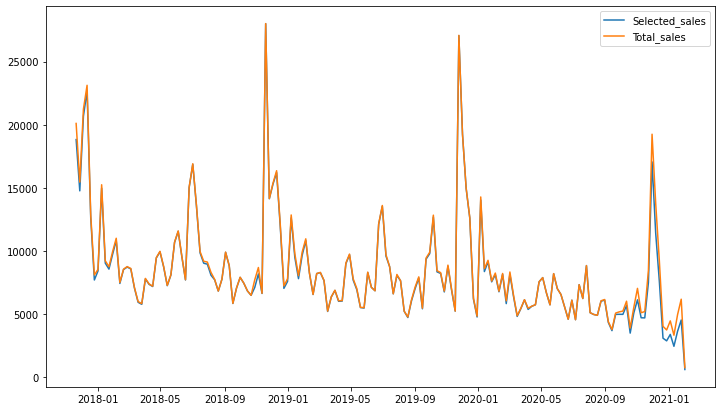

In [28]:
plt.figure(figsize=(12,7))
plt.plot(f_weekly_global_sales, label = 'Selected_sales')
plt.plot(f_weekly_total_sales, label = 'Total_sales')
plt.legend()
plt.show()

There is a decreasing trend. It is caused by the way the products are selected. We will therefore ignore the last week.

## II Learning

### II.A Data Learning Setting

In [39]:
#parameters
horizon = 6 #Prediction horizon
features = ['proportion_shift_6', 'proportion_shift_7','price', 'margin'] # Here are the features used for prediction
target ='proportion'
n_input = len(features)

In [32]:
data_restrained = add_temporal_features(market_shares, horizon=horizon)
data_restrained['price'] = data_restrained['price'] /100
data_restrained.head()

<ipython-input-32-70ae8a21596b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_restrained['price'] = data_restrained['price'] /100


sales  price    margin  sales_somme  proportion  \
product          monday_date                                                    
ASUSZENFM32GOSIL 2018-10-22     5.0   1.99  0.080251       6477.0    0.000772   
                 2018-10-29     2.0   1.99  0.080251       7100.0    0.000282   
                 2018-11-05     2.0   1.99  0.080251       8171.0    0.000245   
                 2018-11-12     4.0   1.99  0.089689       6625.0    0.000604   
                 2018-11-19     1.0   1.99  0.078584      28000.0    0.000036   

                              proportion_shift_6  proportion_shift_7  
product          monday_date                                          
ASUSZENFM32GOSIL 2018-10-22             0.000454            0.000202  
                 2018-10-29             0.000514            0.000454  
                 2018-11-05             0.000993            0.000514  
                 2018-11-12             0.000633            0.000993  
                 2018-11-19             0.000672            0.000633

In [36]:
date_learning =  '2020-06-01' # This date separate learning & testing set
date_stop = '2021_01_01' # This is the end of the testing set
X_train, X_test = data_restrained[data_restrained.index.get_level_values(1) < date_learning ], data_restrained[data_restrained.index.get_level_values(1) >= date_learning ]
X_test = X_test[X_test.index.get_level_values(1) < date_stop]

In [37]:
data_train_loader = dataframe_to_data_loader(X_train,features,target) 
data_test_loader = dataframe_to_data_loader(X_test,features,target) 

Now we present the prediction MAPE of some simple predictor :

    - null : 0
    - simple shift : predicting X_{t-h} for X_t
    - shifted 2-mean :  predicting (X_{t-h}+X_{t-h-1})/2  for X_t

Note that due to the scaling factor present on the Concurrent Neural network model they are not strictly equivalent, due to the arrival of new products. It gives however an reference

In [38]:
#Some reference_MAPE
print('Null MAPE %.2f' %   (100*sum(abs(  X_test['proportion']))/ sum(X_test['proportion'])))
print('Simple_shift MAPE %.2f' %   (100  *sum(abs(X_test['proportion_shift_6'] - X_test['proportion']))/ sum(X_test['proportion'])))
print('Simple 2-mean MAPE %.2f' %  (100  *sum(abs(X_test['proportion_shift_6']/2 + X_test['proportion_shift_7']/2 - X_test['proportion']))/ sum(X_test['proportion'])))

Null MAPE 100.00
Simple_shift MAPE 88.65
Simple 2-mean MAPE 86.96


### II.B Inner Neural Network model

Here we define the inner submodel we will use to compute the "competitiveness function". We stay simple and use a 2 layered neural network

In [40]:
class Feed_forward_model(nn.Module):
    "2 layers neural network used for for testing"

    def __init__(self, n_input, n_hidden):
        super().__init__()
        self.linear_1 = nn.Linear(n_input, n_hidden, bias=False)
        self.linear_2 = nn.Linear(n_hidden, 1, bias=False)
        self.n_input = n_input
        self.n_hidden = n_hidden

    def forward(self, x):
        return F.softplus(self.linear_2(F.relu(self.linear_1(x))), )

n_hidden = 4
submodel = Feed_forward_model(n_input,n_hidden)

### II.C Concurrent neural network

Here is an example using a Concurrent neural network defined in the previous session

In [43]:
from Concurrent_Neural_Network.models import Concurrent_Module

learning_rate = 0.005
epochs = 200
model= Concurrent_Module(submodel, sum_factor=1, loss='L1', learning_rate =learning_rate)

In [44]:
model.train(data_train_loader,eval_dataset=data_test_loader, max_epochs=epochs, batch_print = epochs//10)

Epoch 0
Train MAPE: 109.6920
Test MAPE: 94.6023 

Epoch 20
Train MAPE: 94.0248
Test MAPE: 84.7186 

Epoch 40
Train MAPE: 91.2112
Test MAPE: 83.0338 

Epoch 60
Train MAPE: 90.1645
Test MAPE: 82.6764 

Epoch 80
Train MAPE: 89.7662
Test MAPE: 82.6472 

Epoch 100
Train MAPE: 89.5743
Test MAPE: 83.2569 

Epoch 120
Train MAPE: 89.4895
Test MAPE: 84.0054 

Epoch 140
Train MAPE: 89.4035
Test MAPE: 84.0128 

Epoch 160
Train MAPE: 89.2853
Test MAPE: 83.4951 

Epoch 180
Train MAPE: 89.1918
Test MAPE: 83.3643 



Concurrent Model MAPE 

In [49]:
_ = model.eval(data_test_loader)

Test MAPE: 83.4804 



## III Analysis of the model

We show in this section how to use the model we present in the last parts

### II.A Retrieving results from the model :


In this section, an example of output is provided and the prediction plotted. We first need some function to retrieve the comportement for a unique product

In [50]:
def data_to_position_dict(data, prod):
    date_index = list(set(data.index.get_level_values(1)))#List of the date existing in the dataset
    date_index.sort()
    dict_index_prod = dict()
    for i,dt in enumerate(date_index):
        sub_data = data[data.index.get_level_values(1) == dt]
        l_prod_dt = list(sub_data.index.get_level_values(0))
        if prod in l_prod_dt:
            dict_index_prod[i] = l_prod_dt.index(prod)
    return dict_index_prod

def get_prediction_series(model, dict_index_prod):
    l_prevs = []
    for key in dict_index_prod.keys():
        l_prevs.append(float(model(data_test_loader[key][0])[dict_index_prod[key]]))
    return l_prevs
    

In [51]:
prod = 'HUAWPSMART64BLEU' # The product sales and prediction we want to plot

In [58]:
dict_index_prod = data_to_position_dict(X_test, prod)
sales_product_series = X_test.loc[prod]['proportion']
pred_product_series = pd.Series( data = get_prediction_series(model, dict_index_prod), index = sales_product_series.index)


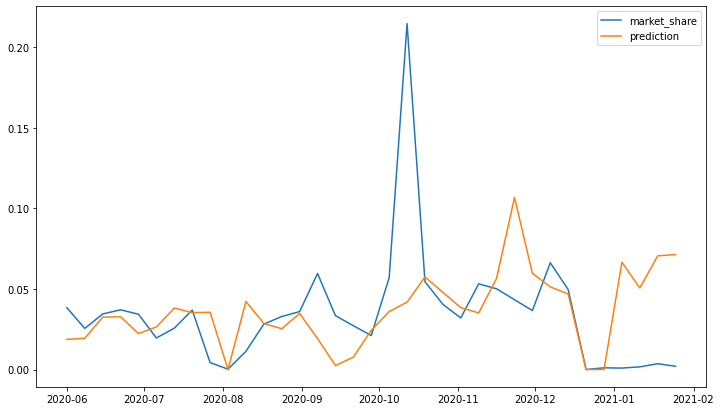

In [60]:
plt.figure(figsize=(12,7))
plt.plot(format_time_index(sales_product_series, 'monday_date'), label ='market_share')
plt.plot(format_time_index(pred_product_series, 'monday_date'), label ='prediction')
plt.legend()
plt.show()

Remember : it is a 6 week in advance prediction